### Importing Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
import warnings
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.saving import register_keras_serializable

2023-11-26 17:49:17.390888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 17:49:17.390964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 17:49:17.394143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 17:49:17.416421: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 17:49:20.199491: W tensorflow/compiler/tf2

In [2]:
logger = tf.get_logger()

@register_keras_serializable()
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Data Cleaning

In [5]:
df = pd.read_csv('data.csv')
df.head()

,text,summary1,summary2
0,My boyfriend and I are long distance. We have ...,Mum is mad at me for not flying on my own tri...,I have made sure my mother is comfortable wit...
1,My landlord left a falsified message taped to ...,My landlord is harassing me and my neighbours...,landlord pretended to be another tenant and w...
2,"A few months ago, I asked my RA if she wanted ...","RA owes me money, made me buy her toys in a f...",RA verbally abused me and I want to get her t...
3,1) I got a DWI in 2014\n\n2) I have a wonderfu...,"10) On a scale from 1-10, how mad would you b...","I am stuck at work, my girlfriend is going to..."
4,So my wedding dress arrived last week. I had s...,"My dress looks different to how I wanted it, ...",My mother asked my dress maker to change the ...


In [6]:
df.drop_duplicates(subset = ['text'], inplace = True)
df.dropna(axis = 0, inplace = True)

df.shape

(20998, 3)

In [18]:
pd.set_option('display.max_colwidth',None)
df.drop('summary2', axis = 1).head(2)

,text,summary1
0,My boyfriend and I are long distance. We have a trip planned this summer which involves me going over to him in the USA. This will be the second time I have actually been with him in person. I am flying from the UK with my mum to the east coast. The original plan was for me to fly over to my boyfriend in the west coast (my parents are holidaying on the east coast) but because my mum was freaking out so much about me going to meet my boyfriend i said we can all road trip there together. I even invited her on the trip with us. I have given her all of our dates so that she can travel around with us.\n\nThe plan was for me to stay on the 4th July and fly back on the 5th. Mum knew this. I told her I had booked a flight back already from the west coast to east coast (where she would pick me up and we would fly back to the UK together). She has gone mad at me because she can't believe I would book a flight when she told me she didn't want me flying on my own. At the time I had booked it she told me she wasn't gonna road trip with us. She knew the trip was happening.......how else was I to get home if I don't fly? \n\nI am fine flying on my own it doesn't bother me at all. I feel like I have done everything I can to make her feel comfortable with this trip and she is just trying to sabotage it. Thoughts??,Mum is mad at me for not flying on my own trip to meet my boyfriend.
1,"My landlord left a falsified message taped to my door for all neighbours to are pretending to be another tenant. \n\nEvidence: \nShe used the same font and size that she uses for all her notes\nOnly she would know where we live and correlate it with where we park\nNeighbours have no problem with us \n\nWe requested from the property management group to have the video tapes looked at and they stated hey did not have time to go on a ""wild goose chase"" I want evidence hard evidence and they denied me. \n\nI want to pursue this further particularly with the human rights board of Canada based in harrassment and predjusice that goes against the human rights code. \n\nThe letter calls us assholes, says we were raised in a barn, says because we are young we should be more competent, calls us pigs, days we make all the neighbours sick. \n\nIt is defamatory as it was pasted for everyone to see. Also we were not born in Canada. \n\nPlease see this website for your information on his situation. \n\nAlso this letter was taped on our door for everyone to see. It was prejudice and defamatory on many levels Adressed in the the human rights code of Manitoba. It was defamation of character for it to be visible To everyone. Please see the following ""\nIt is also contrary to The Code for anyone responsible for rental housing to knowingly permit or fail to take reasonable steps to terminate harassment of one participant by another participant - such as harassment of one tenant by another tenant. (Please also see the sample policies on Discrimination and Harassment at the end of these guidelines.)""",My landlord is harassing me and my neighbours with the same falsified leaflets that she has done in the past. We are seeking to have the evidence examined by the Human Rights Board of Canada.


In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have",
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                       "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                       "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [8]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [9]:
def text_cleaner(text, num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)

    if num == 0:
#         tokens = [w for w in newString.split() if not w in stop_words]
        tokens = newString.split()

    else:
        tokens=newString.split()

    long_words = []
    for i in tokens:
        long_words.append(i)
        
    return (" ".join(long_words)).strip()

In [10]:
cleaned_texts = []

for t in df["text"]:
    cleaned_texts.append(text_cleaner(t, 0))

FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?

In [10]:
cleaned_texts[:3]

['my boyfriend and i are long distance we have a trip planned this summer which involves me going over to him in the usa this will be the second time i have actually been with him in person i am flying from the uk with my mum to the east coast the original plan was for me to fly over to my boyfriend in the west coast but because my mum was freaking out so much about me going to meet my boyfriend i said we can all road trip there together i even invited her on the trip with us i have given her all of our dates so that she can travel around with us the plan was for me to stay on the th july and fly back on the th mum knew this i told her i had booked a flight back already from the west coast to east coast she has gone mad at me because she cannot believe i would book a flight when she told me she did not want me flying on my own at the time i had booked it she told me she was not gonna road trip with us she knew the trip was happening how else was i to get home if i do not fly i am fine 

In [11]:
cleaned_summaries1 = []

for s in df["summary1"]:
    cleaned_summaries1.append(text_cleaner(s, 1))

/tmp/ipykernel_47/2156447478.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [12]:
cleaned_summaries1[:3]

['mum is mad at me for not flying on my own trip to meet my boyfriend',
 'my landlord is harassing me and my neighbours with the same falsified leaflets that she has done in the past we are seeking to have the evidence examined by the human rights board of canada',
 'ra owes me money made me buy her toys in a fundraiser bought my sister toys now owes me dollars how can i get her to pay me']

In [13]:
cleaned_summaries2 = []

for s in df["summary2"]:
    cleaned_summaries2.append(text_cleaner(s, 1))

/tmp/ipykernel_47/2156447478.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [14]:
cleaned_df = pd.DataFrame(columns=["text", "summary1", "summary2"])
cleaned_df["text"] = cleaned_texts
cleaned_df["summary1"] = cleaned_summaries1
cleaned_df["summary2"] = cleaned_summaries2

cleaned_df.head()

,text,summary1,summary2
0,my boyfriend and i are long distance we have a...,mum is mad at me for not flying on my own trip...,i have made sure my mother is comfortable with...
1,my landlord left a falsified message taped to ...,my landlord is harassing me and my neighbours ...,landlord pretended to be another tenant and wr...
2,a few months ago i asked my ra if she wanted t...,ra owes me money made me buy her toys in a fun...,ra verbally abused me and i want to get her to...
3,i got a dwi in i have a wonderful girlfriend w...,on a scale from how mad would you be with you ...,i am stuck at work my girlfriend is going to h...
4,so my wedding dress arrived last week i had sp...,my dress looks different to how i wanted it ho...,my mother asked my dress maker to change the d...


In [15]:
cleaned_df.shape

(20998, 3)

In [16]:
cleaned_df.replace('', np.nan, inplace=True)
cleaned_df.dropna(axis=0,inplace=True)

cleaned_df.shape

(20984, 3)

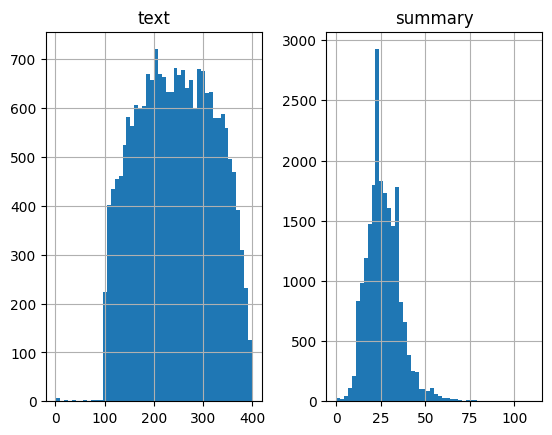

In [17]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split()))

for i in df['summary1']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 50) #more bins per graph is more granular
plt.show()

In [18]:
MAX_TEXT_LEN = 400
MAX_SUMMARY_LEN = 65

In [19]:
cleaned_text = np.array(cleaned_df["text"])
cleaned_summary1 = np.array(cleaned_df["summary1"])
cleaned_summary2 = np.array(cleaned_df["summary2"])

In [20]:
short_text = []
short_summary1 = []

for i in range(len(cleaned_text)):
    if (len(cleaned_summary1[i].split()) <= MAX_SUMMARY_LEN and len(cleaned_text[i].split()) <= MAX_TEXT_LEN):
        short_text.append(cleaned_text[i])
        short_summary1.append(cleaned_summary1[i])

final_dataframe = pd.DataFrame({"text":short_text, "summary1":short_summary1})

In [21]:
final_dataframe["summary1"] = final_dataframe["summary1"].apply(lambda x: "soseq " + x + " eoseq")

In [22]:
final_dataframe.shape

(20844, 2)

### Model Training

In [23]:
texts = np.array(final_dataframe["text"])
summaries = np.array(final_dataframe["summary1"])

In [24]:
x_train, x_val, y_train, y_val = train_test_split(texts, summaries, test_size = 0.10, random_state = 0, shuffle = True)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state = 0, shuffle = True)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

18759 18759
1042 1042
1043 1043


In [25]:
print(f'Text:{x_train[0]}')
print()
print(f'Summary:{y_train[0]}')

Text:a few days ago a few friends of mine invited me if i wanted to go hang out with them i had to decline because i needed to wake up early a few minutes after this conversation i got a text message from one of my friends f texts me jokingly annoyed that i am not coming i honestly do not remember how it happened but she ended up telling me that she and her boyfriend of years broke up about a week ago and was sort of pooring her heart out to me about it i did the normal thing of saying sorry and telling her everything will be okay the things you do to try and make a person feel better i have been texting her a bit over the past couple of days just kind of casually talking and joking mostly just trying to distract her from being upset past that i do not know how to move forward with her i have known her for a few years and have wanted to spend more time with her for a while was never able to because she has always had a boyfriend

Summary:soseq i like girl girl dumped her boyfriend i do

In [26]:
print(f'Text:{x_val[0]}')
print()
print(f'Summary:{y_val[0]}')

Text:my wife and i have been together years married a little over year when we first started dating we were having lots of sex however once we moved in together it quickly went from sex a few times a week to maybe once a month first she said it was stress from work then it was because we werent married finally got married and she said that she was not confident anymore and didnt like being naked over the last year she has lost some weight got into shape and had some surgery done to boost her confidence i was hoping that would help but she still has no interest then it was she didnt want to have sex because she was terrified of getting pregnant so i got a vasectomy still sex only once a month or so in the last years she has initiated sex twice every time i mention sex she says the only thing you care about is sex or im tired or work was terrible we did not even have sex for almost months after we got married i am at the point i dont know what to do it has had a huge effect on my confide

In [27]:
print(f'Text:{x_test[0]}')
print()
print(f'Summary:{y_test[0]}')

Text:my roommate works a minimum wage job so money is tight and does not get financial support from his parents one month he was unemployed and could not make rent so i covered for him since our landlords threatened eviction it happened again recently and i had to cover a couple hundred for him or we were going to be evicted in a matter of days i also usually have to pay utilities since the bills are in my name and he has no money often i even get groceries for him to try to save him money so he can pay rent it comes to a something like a month depending on if we get groceries i do not know how to handle the situation i know he does not have the money to pay me back but i do not want this to happen again and i do not want to get evicted i do not want to have to keep covering for his utilities either the part that gets to me is now he seems uncomfortable around me as a result of this so he makes it feel like we are not even friends anymore he is still can be nice but he is usually in a 

In [28]:
oov_token = "<OOV>"
x_tokenizer = Tokenizer(oov_token=oov_token)
x_tokenizer.fit_on_texts(list(x_train))

In [29]:
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train_seq, maxlen=MAX_TEXT_LEN, padding="post")
x_val = pad_sequences(x_val_seq, maxlen=MAX_TEXT_LEN, padding="post")
x_test = pad_sequences(x_test_seq, maxlen=MAX_TEXT_LEN, padding="post")

x_vocab = len(x_tokenizer.word_index) + 1

In [30]:
print(f'Size of vocabulary (X): {x_vocab}')

Size of vocabulary (X): 34931


In [31]:
oov_token = "<OOV>"
y_tokenizer = Tokenizer(oov_token=oov_token)
y_tokenizer.fit_on_texts(list(y_train))

In [32]:
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train_seq, maxlen=MAX_SUMMARY_LEN, padding="post")
y_val = pad_sequences(y_val_seq, maxlen=MAX_SUMMARY_LEN, padding="post")
y_test = pad_sequences(y_test_seq, maxlen=MAX_SUMMARY_LEN, padding="post")

y_vocab = len(y_tokenizer.word_index) + 1

In [33]:
print(f'Size of vocabulary (y): {y_vocab}')

Size of vocabulary (y): 12761


In [34]:
index = []

for i in range(len(y_train)):
    count = 0
    for j in y_train[i]:
        if j != 0:
            count += 1
    if count == 2:
        index.append(i)

y_train = np.delete(y_train, index, axis=0)
x_train = np.delete(x_train, index, axis=0)

In [35]:
index = []

for i in range(len(y_val)):
    count = 0
    for j in y_val[i]:
        if j != 0:
            count += 1
    if count == 2:
        index.append(i)

y_val = np.delete(y_val, index, axis=0)
x_val = np.delete(x_val, index, axis=0)

In [36]:
index = []

for i in range(len(y_test)):
    count = 0
    for j in y_test[i]:
        if j != 0:
            count += 1
    if count == 2:
        index.append(i)

y_test = np.delete(y_test, index, axis=0)
x_test = np.delete(x_test, index, axis=0)

In [37]:
x_train_m = [x_train, y_train[:,:-1]]
y_train_m = y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:]
x_val_m = [x_val, y_val[:,:-1]]
y_val_m = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]

In [38]:
glove_embeddings_index = {}
embedding_dim = 100

with open('/kaggle/input/glove-embeddings/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs
        
x_embedding_matrix = np.zeros((x_vocab, embedding_dim))

for word, i in x_tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        x_embedding_matrix[i] = embedding_vector
        
y_embedding_matrix = np.zeros((y_vocab, embedding_dim))

for word, i in y_tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        y_embedding_matrix[i] = embedding_vector

In [39]:
EPOCHS = 15
BATCH_SIZE = 128
LATENT_DIM = 50
EMBED_DIM = 100

In [40]:
from keras.initializers import Constant

In [41]:
encoder_input = Input(shape=(MAX_TEXT_LEN, ), name="encoder_input")

encoder_embed = Embedding(x_vocab, embedding_dim, embeddings_initializer=Constant(x_embedding_matrix),
                          input_length=MAX_TEXT_LEN, trainable=False, name="encoder_embedding")(encoder_input)

encoder_lstm1 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_1")
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)

encoder_lstm2 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_2")
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_3")
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

decoder_input = Input(shape=(None, ), name="decoder_input")

decoder_embed_layer = Embedding(y_vocab, embedding_dim, embeddings_initializer=Constant(y_embedding_matrix),
                                input_length=MAX_SUMMARY_LEN, trainable=False, name="decoder_embedding")
decoder_embed = decoder_embed_layer(decoder_input)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="decoder_lstm")
decoder_lstm_output, decoder_h1, decoder_c1 = decoder_lstm(decoder_embed, initial_state=[state_h3, state_c3])

attention_layer = AttentionLayer(name="attention_layer")
attention_output, attention_state = attention_layer([encoder_output3, decoder_lstm_output])

decoder_concat = Concatenate(axis=-1, name="decoder_concat")([decoder_lstm_output, attention_output])

decoder_dense = TimeDistributed(Dense(y_vocab, activation="softmax"))
decoder_output = decoder_dense(decoder_concat)

model = Model([encoder_input, decoder_input], decoder_output)

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 400)]                0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 400, 100)             3493100   ['encoder_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 enc_lstm_1 (LSTM)           [(None, 400, 50),            30200     ['encoder_embedding[0][0]']   
                              (None, 50),                                                         
                              (None, 50)]                                                     

In [43]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=0.001)

In [45]:
history = model.fit(x_train_m, y_train_m, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val_m, y_val_m),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/15
147/147 [==============================] - 606s 4s/step - loss: 4.2834 - accuracy: 0.5582 - val_loss: 2.7589 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 2/15
147/147 [==============================] - 592s 4s/step - loss: 2.6764 - accuracy: 0.5763 - val_loss: 2.6124 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 3/15
147/147 [==============================] - 599s 4s/step - loss: 2.5828 - accuracy: 0.5902 - val_loss: 2.5376 - val_accuracy: 0.5999 - lr: 0.0010
Epoch 4/15
147/147 [==============================] - 599s 4s/step - loss: 2.5081 - accuracy: 0.6039 - val_loss: 2.4601 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 5/15
147/147 [==============================] - 600s 4s/step - loss: 2.4383 - accuracy: 0.6124 - val_loss: 2.3898 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 6/15
147/147 [==============================] - 611s 4s/step - loss: 2.3791 - accuracy: 0.6197 - val_loss: 2.3333 - val_accuracy: 0.6278 - lr: 0.0010
Epoch 7/15
147/147 [==============================] - 602s 4s/st

In [46]:
from tensorflow.keras.models import load_model
model.save('/kaggle/working/reddit_model_1.keras')

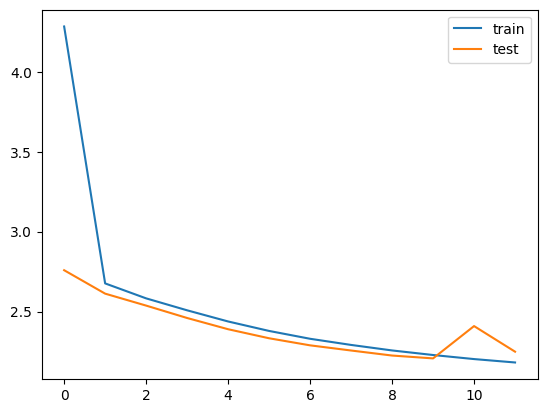

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [54]:
with open('xtokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ytokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [48]:
# Encoder model (unchanged)
encoder_model = Model(encoder_input, outputs=[encoder_output3, state_h3, state_c3])

# Decoder input states (unchanged)
decoder_input_state_h = Input(shape=(LATENT_DIM,))
decoder_input_state_c = Input(shape=(LATENT_DIM,))

# Decoder input hidden states from the encoder (unchanged)
decoder_input_state_hidden = Input(shape=(MAX_TEXT_LEN, LATENT_DIM))

# Decoder embedding and LSTM layers (unchanged)
decoder_embedding_pred = decoder_embed_layer(decoder_input)
decoder_output_p, state_h_p, state_c_p = decoder_lstm(
    decoder_embedding_pred, initial_state=[decoder_input_state_h, decoder_input_state_c]
)

# Attention layer (unchanged)
attention_out_inference, attention_state_inference = attention_layer(
    [decoder_input_state_hidden, decoder_output_p]
)

# Concatenate the LSTM output and attention output (unchanged)
decoder_concat = Concatenate(axis=-1, name="decoder_concat")([decoder_output_p, attention_out_inference])

# Final Dense layer for prediction (unchanged)
decoder_final_output = decoder_dense(decoder_concat)

# Decoder model (unchanged)
decoder_model = Model(
    [decoder_input] + [decoder_input_state_hidden, decoder_input_state_h, decoder_input_state_c],
    [decoder_final_output] + [state_h_p, state_c_p]
)

In [62]:
from queue import PriorityQueue

def beam_search_decoder(input_sequence, beam_width=3):
    # Get the encoder output, hidden state, and cell state by predicting on the input_sequence
    encoder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence, verbose=None)

    # Initialize the beam search queue with the start-of-sequence token
    initial_beam = [(0, [target_word_index["soseq"]], encoder_h, encoder_c)]
    beam_queue = PriorityQueue()
    for initial_state in initial_beam:
        beam_queue.put(initial_state)

    # Continue decoding until the beam search queue is empty
    while not beam_queue.empty():
        # Get the current beam from the queue
        score, current_sequence, current_h, current_c = beam_queue.get()

        # Get the last predicted token in the sequence
        last_token = current_sequence[-1]

        # If the last token is the end-of-sequence token, add the sequence to the final candidates
        if last_token == target_word_index["eoseq"]:
            final_candidates.append((score, current_sequence))
            continue

        # Predict the next token in the target sequence using the decoder model
        output_token, h, c = decoder_model.predict([np.array([[last_token]]), [encoder_output, current_h, current_c]], verbose=None)

        # Get the top-k candidate tokens based on their probabilities
        top_candidates = np.argsort(output_token[0, -1, :])[-beam_width:][::-1]

        # Expand the beam with the top-k candidate tokens
        for token_index in top_candidates:
            new_sequence = current_sequence + [token_index]
            new_score = score - np.log(output_token[0, -1, token_index])

            beam_queue.put((new_score, new_sequence, h, c))

    # Return the sequence with the highest probability from the final candidates
    best_score, best_sequence = max(final_candidates, key=lambda x: -x[0])
    decoded_sentence = " ".join(reverse_target_word_index[token] for token in best_sequence[1:-1])

    return decoded_sentence

In [58]:
def sequence_to_summary(input_sequence):
    sentence = ""
    for i in input_sequence:
        if i == target_word_index["eoseq"]:
            break
        if i != 0 and i != target_word_index["soseq"]:
            sentence = sentence + reverse_target_word_index.get(i, "<OOV>") + " "
    return sentence.strip()

In [52]:
def sequence_to_text(input_seuqnece):
    sentence = ""
    for i in input_seuqnece:
        if i != 0 :
            sentence = sentence + reverse_source_word_index[i] + " "

    return sentence

In [ ]:
print("Review:", sequence_to_text(x_test[0]))
print("Original summary:", sequence_to_summary(y_test[0]))
print("Predicted summary:", beam_search_decoder(x_test[0].reshape(1,MAX_TEXT_LEN)))

Review: my roommate works a minimum wage job so money is tight and does not get financial support from his parents one month he was unemployed and could not make rent so i covered for him since our landlords threatened eviction it happened again recently and i had to cover a couple hundred for him or we were going to be evicted in a matter of days i also usually have to pay utilities since the bills are in my name and he has no money often i even get groceries for him to try to save him money so he can pay rent it comes to a something like a month depending on if we get groceries i do not know how to handle the situation i know he does not have the money to pay me back but i do not want this to happen again and i do not want to get evicted i do not want to have to keep covering for his utilities either the part that gets to me is now he seems uncomfortable around me as a result of this so he makes it feel like we are not even friends anymore he is still can be nice but he is usually in

In [ ]:
encoder_model = Model(encoder_input, outputs=[encoder_output3, state_h3, state_c3])

decoder_input_state_h = Input(shape=(LATENT_DIM, ))
decoder_input_state_c = Input(shape=(LATENT_DIM, ))
decoder_input_state_hidden = Input(shape=(MAX_TEXT_LEN, LATENT_DIM))

decoder_embedding_pred = decoder_embed_layer(decoder_input)
decoder_output_p, state_h_p, state_c_p = decoder_lstm(decoder_embedding_pred, initial_state=[decoder_input_state_h, decoder_input_state_c])

attention_out_inference, attention_state_inference = attention_layer([decoder_input_state_hidden, decoder_output_p])
decoder_concat = Concatenate(axis=-1, name="concat_attention")([decoder_output_p, attention_out_inference])

decoder_final_output = decoder_dense(decoder_concat)

decoder_model = Model(
    [decoder_input] + [decoder_input_state_hidden, decoder_input_state_h, decoder_input_state_c],
    [decoder_final_output] + [state_h_p, state_c_p])

In [ ]:
from queue import PriorityQueue

def beam_search_decoder(input_sequence, beam_width=3):
    # Get the encoder output, hidden state, and cell state by predicting on the input_sequence
    encoder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence, verbose=None)

    # Initialize the beam search queue with the start-of-sequence token
    initial_beam = [(0, [target_word_index["soseq"]], encoder_h, encoder_c)]
    beam_queue = PriorityQueue()
    for initial_state in initial_beam:
        beam_queue.put(initial_state)

    # Continue decoding until the beam search queue is empty
    while not beam_queue.empty():
        # Get the current beam from the queue
        score, current_sequence, current_h, current_c = beam_queue.get()

        # Get the last predicted token in the sequence
        last_token = current_sequence[-1]

        # If the last token is the end-of-sequence token, add the sequence to the final candidates
        if last_token == target_word_index["eoseq"]:
            final_candidates.append((score, current_sequence))
            continue

        # Predict the next token in the target sequence using the decoder model
        output_token, h, c = decoder_model.predict([np.array([[last_token]]), [encoder_output, current_h, current_c]], verbose=None)

        # Get the top-k candidate tokens based on their probabilities
        top_candidates = np.argsort(output_token[0, -1, :])[-beam_width:][::-1]

        # Expand the beam with the top-k candidate tokens
        for token_index in top_candidates:
            new_sequence = current_sequence + [token_index]
            new_score = score - np.log(output_token[0, -1, token_index])

            beam_queue.put((new_score, new_sequence, h, c))

    # Return the sequence with the highest probability from the final candidates
    best_score, best_sequence = max(final_candidates, key=lambda x: -x[0])
    decoded_sentence = " ".join(reverse_target_word_index[token] for token in best_sequence[1:-1])

    return decoded_sentence                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               